In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import csv

from hyperopt import fmin
from hyperopt import hp
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer, PowerTransformer

from timeit import default_timer as timer

import sdss_gz_data as sgd
from sdss_gz_data import SPIRIAL_GALAXY_TYPE
from sdss_gz_data import ELLIPTICAL_GALAXY_TYPE
from sdss_gz_data import UNKNOWN_GALAXY_TYPE

from joblib import Parallel, delayed

import matplotlib.pyplot as plt

In [3]:
%ls -l data/

total 1651496
-rw-r--r--@ 1 will  staff      42029  6 Apr 20:34 1237648720693755918.png
-rw-r--r--@ 1 will  staff      48342  6 Apr 20:34 1237648720693756035.png
-rw-r--r--@ 1 will  staff      36069  6 Apr 20:34 1237648720693756115.png
-rw-r--r--@ 1 will  staff      37825  6 Apr 20:34 1237648720693756163.png
-rw-r--r--@ 1 will  staff      37626  6 Apr 20:34 1237648720693756176.png
-rw-r--r--@ 1 will  staff  349816837 11 Mar 15:14 astromonical_data.csv.gz
drwxr-xr-x  4 will  staff        128  6 Apr 16:18 fits/
-rw-r--r--  1 will  staff   12208320  6 Apr 20:34 frame-g-000756-2-0427.fits
-rw-r--r--  1 will  staff   12208320  6 Apr 20:34 frame-i-000756-2-0427.fits
-rw-r--r--  1 will  staff   12208320  6 Apr 20:34 frame-r-000756-2-0427.fits
-rw-r--r--@ 1 will  staff  319952110 31 Jan 20:01 input.csv
-rw-r--r--  1 will  staff    4320000  6 Apr 20:34 obj-1237648720693755918.fits
-rw-r--r--  1 will  staff    4320000  6 Apr 20:34 obj-1237648720693756035.fits
-rw-r--r--  1 will  staff    4320000

In [4]:
features = sgd.generate_features()
features

['dered_u',
 'petroRad_u',
 'petroR50_u',
 'petroR90_u',
 'petro_R90_R50_ratio_u',
 'petroMag_u',
 'expRad_u',
 'deVRad_u',
 'psfMag_u',
 'expMag_u',
 'fiberMag_u',
 'extinction_u',
 'expAB_u',
 'expPhi_u',
 'deVAB_u',
 'deVPhi_u',
 'mag_u',
 'stokes_q_u',
 'stokes_u_u',
 'dered_g',
 'petroRad_g',
 'petroR50_g',
 'petroR90_g',
 'petro_R90_R50_ratio_g',
 'petroMag_g',
 'expRad_g',
 'deVRad_g',
 'psfMag_g',
 'expMag_g',
 'fiberMag_g',
 'extinction_g',
 'expAB_g',
 'expPhi_g',
 'deVAB_g',
 'deVPhi_g',
 'mag_g',
 'stokes_q_g',
 'stokes_u_g',
 'petro_g_u_colour_index',
 'model_g_u_colour_index',
 'psfMag_g_u_colour_index',
 'dered_i',
 'petroRad_i',
 'petroR50_i',
 'petroR90_i',
 'petro_R90_R50_ratio_i',
 'petroMag_i',
 'expRad_i',
 'deVRad_i',
 'psfMag_i',
 'expMag_i',
 'fiberMag_i',
 'extinction_i',
 'expAB_i',
 'expPhi_i',
 'deVAB_i',
 'deVPhi_i',
 'mag_i',
 'stokes_q_i',
 'stokes_u_i',
 'petro_i_r_colour_index',
 'model_i_r_colour_index',
 'psfMag_i_r_colour_index',
 'dered_r',
 'petroR

In [5]:
orig_data = sgd.load_data('data/astromonical_data.csv.gz')

In [6]:
prepared_data = sgd.prepare_data(orig_data)

Filtered out 3501 invalid records
Number of high z galaxies = 231
% elliptical:      0.13576908942272356
% spiral:          0.2237143092857732
% unknown:         0.6405166012915032
% spiral of known: 0.6223216707350149


In [7]:
transformed_data = sgd.transform_data(prepared_data)

In [8]:
X = transformed_data[features]
y = transformed_data['z']

In [219]:
len(transformed_data)

533332

In [220]:
known_galaxy_type_idx = transformed_data.galaxy_type != sgd.UNKNOWN_GALAXY_TYPE

X = X[known_galaxy_type_idx]
y = y[known_galaxy_type_idx]

In [221]:
len(X)

191724

In [9]:
def split_train(X, y, random_state=None, num_bins=24, min_y=-3, max_y=3, test_size=0.2):
    # Need to stratify y, but should scale y to make it a better distribution
    y_norm = y ** 1/3
    
    bins = np.linspace(min(y_norm - 1e-5), max(y_norm + 1e-5) , num_bins)
    y_binned = np.digitize(y_norm, bins)

    print(f'Min z:             {min(y)}')
    print(f'Max z:             {max(y)}')
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y_binned)

In [222]:
X_train, X_test, y_train, y_test = split_train(X, y, random_state=42)

Min z:             -0.0035549390000000004
Max z:             0.3936197


In [166]:
def z_err(preds, train_data):
    if hasattr(train_data,'label'):
        train_data = train_data.label
    train_data = train_data.ravel()
    preds = preds.ravel()

    error = np.abs((train_data - preds)/(1 + train_data)).mean()
    return 'z_err', error, False

def z_err_stats(actual, predicted):
    err = np.abs((predicted - actual)/(1 + actual))
    num_cat_failure = len(err[err > 0.15])
    num_records = len(err)
    
    catastrophic_failure = num_cat_failure / num_records
    
    return err.mean(), np.std(err), np.min(err), np.max(err), catastrophic_failure

## Hyperparamter Search

In [79]:
N_FOLDS = 5

hp_out_file = 'gbm_hp_trials.csv'
of_connection = open(hp_out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

def objective(X_train, y_train, random_state=42, stratified=True):
    def _objective(params, n_folds=N_FOLDS):
        # Keep track of evals
        global ITERATION

        ITERATION += 1

        # Make sure parameters that need to be integers are integers
        for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
            params[parameter_name] = int(params[parameter_name])

        params['boosting_type'] = 'gbdt'
        train_set = lgb.Dataset(X_train, y_train)
        
        start = timer()
        cv_results = lgb.cv(params, train_set, nfold=n_folds, num_boost_round=1000,
                           early_stopping_rounds=100,
                           metrics='mae', feval=z_err, seed=random_state, stratified=stratified)
        run_time = timer() - start
        
        best_score = max(cv_results['z_err-mean'])

        # need a function to minimise
        loss = best_score
        
        # Boosting rounds that returned the highest cv score
        n_estimators = int(np.argmax(cv_results['z_err-mean']) + 1)

        if ITERATION % 10 == 0:
            # Display the information
            display('Iteration {}: {} Fold CV Z ERR ROC {:.5f}'.format(ITERATION, N_FOLDS, best_score))

        of_connection = open(hp_out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow([loss, params, ITERATION, n_estimators, run_time])
        of_connection.close()

        # Dictionary with information for evaluation
        return {'loss': loss, 'params': params, 'iteration': ITERATION,
                'estimators': n_estimators, 
                'train_time': run_time, 'status': STATUS_OK}

    return _objective

In [80]:
space = {
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [81]:
ITERATION = 0
MAX_EVALS = 1000

tpe_algorithm = tpe.suggest
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective(X_train, y_train, stratified=False), space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

  1%|          | 9/1000 [1:02:09<106:40:57, 387.55s/it, best loss: 0.03440363078067864]

'Iteration 10: 5 Fold CV Z ERR ROC 0.03809'

  2%|▏         | 19/1000 [2:03:19<98:52:44, 362.86s/it, best loss: 0.031225586963904022] 

'Iteration 20: 5 Fold CV Z ERR ROC 0.03492'

  3%|▎         | 29/1000 [2:38:01<61:51:34, 229.35s/it, best loss: 0.0295904100164239]  

'Iteration 30: 5 Fold CV Z ERR ROC 0.03588'

  4%|▍         | 39/1000 [3:29:39<79:29:38, 297.79s/it, best loss: 0.0295904100164239]

'Iteration 40: 5 Fold CV Z ERR ROC 0.03781'

  5%|▍         | 49/1000 [4:21:02<95:24:51, 361.19s/it, best loss: 0.0295904100164239]

'Iteration 50: 5 Fold CV Z ERR ROC 0.03634'

  6%|▌         | 59/1000 [4:59:25<58:08:55, 222.46s/it, best loss: 0.0295904100164239]

'Iteration 60: 5 Fold CV Z ERR ROC 0.03621'

  7%|▋         | 69/1000 [5:38:06<43:48:25, 169.39s/it, best loss: 0.0295904100164239]

'Iteration 70: 5 Fold CV Z ERR ROC 0.03091'

  8%|▊         | 79/1000 [6:18:09<57:15:58, 223.84s/it, best loss: 0.0295904100164239]

'Iteration 80: 5 Fold CV Z ERR ROC 0.03819'

  9%|▉         | 89/1000 [7:03:09<77:25:24, 305.95s/it, best loss: 0.0295904100164239]

'Iteration 90: 5 Fold CV Z ERR ROC 0.03840'

 10%|▉         | 99/1000 [7:43:11<67:37:40, 270.21s/it, best loss: 0.029406148171989298]

'Iteration 100: 5 Fold CV Z ERR ROC 0.03255'

 11%|█         | 109/1000 [8:42:11<75:56:42, 306.85s/it, best loss: 0.029406148171989298] 

'Iteration 110: 5 Fold CV Z ERR ROC 0.03490'

 12%|█▏        | 119/1000 [9:27:48<61:46:04, 252.40s/it, best loss: 0.029406148171989298]

'Iteration 120: 5 Fold CV Z ERR ROC 0.03418'

 13%|█▎        | 129/1000 [10:22:30<90:57:32, 375.95s/it, best loss: 0.029381319618255804]

'Iteration 130: 5 Fold CV Z ERR ROC 0.03700'

 14%|█▍        | 139/1000 [11:19:21<74:18:33, 310.70s/it, best loss: 0.029381319618255804]

'Iteration 140: 5 Fold CV Z ERR ROC 0.03511'

 15%|█▍        | 149/1000 [11:57:56<50:01:17, 211.61s/it, best loss: 0.029381319618255804]

'Iteration 150: 5 Fold CV Z ERR ROC 0.02973'

 16%|█▌        | 159/1000 [12:28:19<41:38:55, 178.28s/it, best loss: 0.029381319618255804]

'Iteration 160: 5 Fold CV Z ERR ROC 0.03574'

 17%|█▋        | 169/1000 [13:12:37<55:28:51, 240.35s/it, best loss: 0.029381319618255804]

'Iteration 170: 5 Fold CV Z ERR ROC 0.03242'

 18%|█▊        | 179/1000 [14:05:55<76:02:18, 333.42s/it, best loss: 0.029381319618255804]

'Iteration 180: 5 Fold CV Z ERR ROC 0.03443'

 19%|█▉        | 189/1000 [15:10:36<80:55:17, 359.21s/it, best loss: 0.029380648452877318] 

'Iteration 190: 5 Fold CV Z ERR ROC 0.03871'

 20%|█▉        | 199/1000 [15:58:56<66:51:29, 300.49s/it, best loss: 0.029380648452877318]

'Iteration 200: 5 Fold CV Z ERR ROC 0.03823'

 21%|██        | 209/1000 [16:49:25<60:12:36, 274.03s/it, best loss: 0.029380648452877318]

'Iteration 210: 5 Fold CV Z ERR ROC 0.03257'

 22%|██▏       | 219/1000 [17:43:44<68:40:47, 316.58s/it, best loss: 0.029380648452877318]

'Iteration 220: 5 Fold CV Z ERR ROC 0.03878'

 23%|██▎       | 229/1000 [18:38:44<71:00:11, 331.53s/it, best loss: 0.029380648452877318]

'Iteration 230: 5 Fold CV Z ERR ROC 0.02952'

 24%|██▍       | 239/1000 [19:20:28<49:05:09, 232.21s/it, best loss: 0.029380648452877318]

'Iteration 240: 5 Fold CV Z ERR ROC 0.03874'

 25%|██▍       | 249/1000 [20:21:36<74:55:42, 359.18s/it, best loss: 0.029380648452877318]

'Iteration 250: 5 Fold CV Z ERR ROC 0.03164'

 25%|██▌       | 250/1000 [20:24:19<62:32:20, 300.19s/it, best loss: 0.029380648452877318]


KeyboardInterrupt: 

In [58]:
hyperparams = bayes_trials.best_trial['result']['params'].copy()
hyperparams['class_weight'] = None
hyperparams

NameError: name 'bayes_trials' is not defined

## K-Folds

In [12]:
# hyperparams = {
# #     'class_weight': 'balanced',
#     'num_leaves': 150,
#     'learning_rate': 0.1,
# #    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
# #    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
# #    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
# #    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
# #    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
# }

hyperparams = {
    'colsample_bytree': 0.8692111259587726,
    'learning_rate': 0.2971068599942397,
    'min_child_samples': 115,
    'num_leaves': 138,
    'reg_alpha': 0.8091564930846249,
    'reg_lambda': 0.7689270267722382,
    'subsample_for_bin': 40000,
    'boosting_type': 'gbdt',
    'class_weight': None
}

In [13]:
def mae(y, y_pred):
    y = y.ravel()
    y_pred = y_pred.ravel()
    return np.abs(y - y_pred).mean()

In [14]:
def kfolds(x_train, x_test, y_train, y_test, n_splits=5, random_state=1138, verbose=True, features=None):
    if (features is not None):
        x_train = x_train[list(features)]
        x_test = x_test[list(features)]

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds = np.zeros(X_train.shape[0])
    predictions = np.zeros(X_test.shape[0])

    models = []
    
    for n_fold, (train_index, validate_index) in enumerate(folds.split(x_train, y_train)):
        X_t, X_v = x_train.iloc[train_index], x_train.iloc[validate_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[validate_index]

        clf = lgb.LGBMRegressor(**hyperparams)

        clf.fit(X_t, y_t, eval_set=[(X_v, y_v)],
                early_stopping_rounds=100,
                eval_metric=z_err,
                verbose=False,
        )

        oof_preds[validate_index] = clf.predict(X_v, num_iteration=clf.best_iteration_)
        predictions += clf.predict(x_test, num_iteration=clf.best_iteration_)/n_splits

        if (verbose):
            print('Fold %2d Z err: %.6f, std: %.6f, min: %.6f, max: %.6f, cat. failure: %.6f' % (n_fold + 1, *z_err_stats(y_v, oof_preds[validate_index])))
            
        models.append(clf)
        del clf, X_t, X_v, y_t, y_v

    result, _, _, _, _ = z_err_stats(y_test, predictions)
    if (verbose):
        print('Full Z err: %.6f, std: %.6f, min: %.6f, max: %.6f, cat. failure: %.6f' % z_err_stats(y_test, predictions))
    return result, models

In [27]:
def predict(models, x_test, features=None):
    if (features is not None):
        x_test = x_test[features]

    num_of_models = len(models)
    predictions = np.zeros(x_test.shape[0])

    for idx, model in enumerate(models):
        predictions += model.predict(x_test, num_iteration=model.best_iteration_)/num_of_models

    return predictions

In [16]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

NO_BEST_FEATURE = ''
NO_BEST_Z_ERR = -1

def get_feature_score(features):
    z_err, models = kfolds(X_train[features], X_test[features], y_train, y_test, verbose=False)
    return z_err

# Model colour indexes are the base features. Everything else additional
def determine_best_features(base_features, base_z_err, bad_features):

    def best_z_err_results(results):
        if (len(results) == 0):
            return NO_BEST_FEATURE, NO_BEST_Z_ERR

        best_feature, best_z_err = min(results.items(), key=lambda x:x[1])
        return best_feature, best_z_err

    def process(results):
        def _process(feature):
            print(f'Checking feature: {feature}')
            run_features = base_features.copy()
            run_features.add(feature)

            curr_z_err = get_feature_score(run_features)

            if (curr_z_err > base_z_err):
                print(f'WARNING - {feature} reduces model accuracy!!!')
                bad_features.add(feature)
            else:
                results[feature] = curr_z_err
            
                best_feature, best_z_err = best_z_err_results(results)
                if (best_feature == feature):
                    print(f'{feature} has best z_err score {curr_z_err:0.6f}')

            return (curr_z_err, feature)

        return _process
    
    print(f'Base z_err: {base_z_err:0.6f}')

    features_to_scan = set(features)
    features_to_scan = features_to_scan.difference(base_features).difference(bad_features)
    
    results = {}

    print(f'Checking {len(features_to_scan)} features... this might take awhile')
    process_feature = process(results)
    _ = Parallel(n_jobs=num_cores, verbose=1, backend="threading")(map(delayed(process_feature), features_to_scan))
    
    best_feature, best_z_err = best_z_err_results(results)

    return results, best_z_err, best_feature

In [103]:
_ = kfolds(X_train, X_test, y_train, y_test)

8 85333
Fold  1 Z err: 0.010565, std: 0.010069, min: 0.000000, max: 0.209609, cat. failure: 0.000094
5 85333
Fold  2 Z err: 0.010612, std: 0.010102, min: 0.000000, max: 0.206871, cat. failure: 0.000059
12 85333
Fold  3 Z err: 0.010655, std: 0.010229, min: 0.000000, max: 0.244457, cat. failure: 0.000141
15 85333
Fold  4 Z err: 0.010666, std: 0.010245, min: 0.000000, max: 0.239890, cat. failure: 0.000176
16 85333
Fold  5 Z err: 0.010646, std: 0.010274, min: 0.000000, max: 0.260508, cat. failure: 0.000188
12 106667


ValueError: too many values to unpack (expected 4)

In [29]:
base_features = set([
#     'psfMag_r',
#     'psfMag_g_u_colour_index',
#     'psfMag_r_g_colour_index',
#     'psfMag_i_r_colour_index',
#     'psfMag_z_i_colour_index',
#     'dered_r',
#     'model_g_u_colour_index',
#     'model_r_g_colour_index',
#     'model_i_r_colour_index',
#     'model_z_i_colour_index',
])
base_z_err = 1.0 #get_feature_score(list(base_features))

extra_base_features = []
all_bad_features = set([])

for idx in range(15):
    base_features.update(extra_base_features)
    print(f'Starting a round {idx} to find best feature. Current extra features = {extra_base_features}')
    feature_results, best_z_err, best_feature = determine_best_features(base_features, base_z_err, all_bad_features)
    
    if (best_feature == NO_BEST_FEATURE):
        print('No new feature found. Exiting')
        break
    
    print(f'Found {best_feature} as extra feature')
    extra_base_features.append(best_feature)
    base_z_err = best_z_err

base_features.update(extra_base_features)
print(f'Final extra features = {extra_base_features}')

Starting a round 0 to find best feature. Current extra features = []
Base z_err: 1.000000
Checking 107 features... this might take awhile
Checking feature: psfMag_rChecking feature: petroR90_u
Checking feature: petroR50_z
Checking feature: psfMag_z



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


psfMag_z has best z_err score 0.032311
Checking feature: petroR90_r
Checking feature: mag_z
Checking feature: fiberMag_r
Checking feature: expPhi_r
mag_z has best z_err score 0.032227
Checking feature: expRad_u
Checking feature: extinction_u
Checking feature: expPhi_g
Checking feature: dered_z
Checking feature: deVAB_g
Checking feature: psfMag_i_r_colour_index
dered_z has best z_err score 0.032201
Checking feature: deVRad_u
Checking feature: stokes_q_r
Checking feature: petroRad_u
Checking feature: expPhi_i
Checking feature: dered_g
Checking feature: petro_i_r_colour_index
dered_g has best z_err score 0.025349
Checking feature: deVRad_r
Checking feature: stokes_q_z
Checking feature: dered_i
Checking feature: petro_R90_R50_ratio_z
Checking feature: petroR90_i
Checking feature: petroR50_i
Checking feature: petroMag_r
Checking feature: petro_r_g_colour_index
Checking feature: deVPhi_u
Checking feature: psfMag_z_i_colour_index
petro_r_g_colour_index has best z_err score 0.024217
Checking f

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 14.1min


Checking feature: deVRad_i
Checking feature: deVPhi_r
Checking feature: stokes_u_u
Checking feature: deVAB_i
Checking feature: dered_u
Checking feature: extinction_z
Checking feature: expRad_r
Checking feature: deVAB_r
Checking feature: mag_i
Checking feature: mag_r
Checking feature: stokes_u_i
Checking feature: deVAB_z
Checking feature: petro_R90_R50_ratio_i
Checking feature: mag_u
Checking feature: psfMag_g_u_colour_index
Checking feature: stokes_u_g
Checking feature: model_i_r_colour_index
Checking feature: expAB_i
Checking feature: petro_R90_R50_ratio_r
Checking feature: expMag_u
Checking feature: stokes_q_i
Checking feature: petroR90_z
Checking feature: extinction_g
Checking feature: petroMag_g
Checking feature: mag_g
Checking feature: expMag_g
Checking feature: expAB_z
Checking feature: deVRad_z
Checking feature: expRad_g
Checking feature: deVAB_u
Checking feature: expMag_z
Checking feature: petro_R90_R50_ratio_g
Checking feature: psfMag_g
Checking feature: extinction_i
Checking 

[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed: 33.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found model_r_g_colour_index as extra feature
Starting a round 1 to find best feature. Current extra features = ['model_r_g_colour_index']
Base z_err: 0.022289
Checking 106 features... this might take awhile
Checking feature: psfMag_rChecking feature: petroR90_u

Checking feature: petroR50_z
Checking feature: psfMag_z
psfMag_z has best z_err score 0.018714
Checking feature: petroR90_r
Checking feature: mag_z
Checking feature: fiberMag_r
Checking feature: expPhi_r
Checking feature: expRad_u
Checking feature: extinction_u
fiberMag_r has best z_err score 0.018582
Checking feature: expPhi_g
WARNING - expPhi_r reduces model accuracy!!!
Checking feature: dered_z
Checking feature: deVAB_g
Checking feature: psfMag_i_r_colour_index
WARNING - expPhi_g reduces model accuracy!!!
Checking feature: deVRad_u
Checking feature: stokes_q_r
Checking feature: petroRad_u
Checking feature: expPhi_i
Checking feature: dered_g
Checking feature: petro_i_r_colour_index
Checking feature: deVRad_r
Checking feature

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 12.3min


Checking feature: fiberMag_i
Checking feature: deVRad_i
Checking feature: deVPhi_r
Checking feature: stokes_u_u
Checking feature: deVAB_i
Checking feature: dered_u
Checking feature: extinction_z
WARNING - deVPhi_r reduces model accuracy!!!
Checking feature: expRad_r
Checking feature: deVAB_r
Checking feature: mag_i
Checking feature: mag_r
Checking feature: stokes_u_i
Checking feature: deVAB_z
Checking feature: petro_R90_R50_ratio_i
Checking feature: mag_u
Checking feature: psfMag_g_u_colour_index
Checking feature: stokes_u_g
Checking feature: model_i_r_colour_index
Checking feature: expAB_i
Checking feature: petro_R90_R50_ratio_r
Checking feature: expMag_u
Checking feature: stokes_q_i
Checking feature: petroR90_z
Checking feature: extinction_g
Checking feature: petroMag_g
Checking feature: mag_g
Checking feature: expMag_g
Checking feature: expAB_z
Checking feature: deVRad_z
Checking feature: expRad_g
Checking feature: deVAB_u
Checking feature: expMag_z
Checking feature: petro_R90_R50_r

[Parallel(n_jobs=4)]: Done 106 out of 106 | elapsed: 27.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found model_g_u_colour_index as extra feature
Starting a round 2 to find best feature. Current extra features = ['model_r_g_colour_index', 'model_g_u_colour_index']
Base z_err: 0.017539
Checking 93 features... this might take awhile
Checking feature: psfMag_r
Checking feature: petroR90_uChecking feature: petroR50_z

Checking feature: psfMag_z
petroR50_z has best z_err score 0.015611
Checking feature: petroR90_r
psfMag_r has best z_err score 0.014959
Checking feature: mag_z
Checking feature: fiberMag_r
psfMag_z has best z_err score 0.014824
Checking feature: expRad_u
fiberMag_r has best z_err score 0.014657
Checking feature: extinction_u
Checking feature: dered_z
mag_z has best z_err score 0.014648
Checking feature: deVAB_g
Checking feature: psfMag_i_r_colour_index
Checking feature: deVRad_u
Checking feature: stokes_q_r
Checking feature: petroRad_u
Checking feature: dered_g
Checking feature: petro_i_r_colour_index
Checking feature: deVRad_r
Checking feature: stokes_q_z
Checking feature:

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 20.3min


Checking feature: expRad_r
Checking feature: deVAB_r
Checking feature: mag_i
Checking feature: mag_r
Checking feature: stokes_u_i
Checking feature: deVAB_z
Checking feature: petro_R90_R50_ratio_i
Checking feature: mag_u
Checking feature: psfMag_g_u_colour_index
Checking feature: stokes_u_g
Checking feature: model_i_r_colour_index
Checking feature: expAB_i
Checking feature: petro_R90_R50_ratio_r
Checking feature: expMag_u
Checking feature: stokes_q_i
Checking feature: petroR90_z
Checking feature: extinction_g
Checking feature: petroMag_g
Checking feature: mag_g
Checking feature: expMag_g
Checking feature: expAB_z
Checking feature: deVRad_z
Checking feature: expRad_g
Checking feature: deVAB_u
Checking feature: expMag_z
Checking feature: petro_R90_R50_ratio_g
Checking feature: psfMag_g
Checking feature: extinction_i
Checking feature: deVRad_g
Checking feature: dered_r
Checking feature: expMag_r
Checking feature: petroR50_u
Checking feature: petroR90_g
Checking feature: petroRad_z
Checking

[Parallel(n_jobs=4)]: Done  93 out of  93 | elapsed: 43.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found fiberMag_z as extra feature
Starting a round 3 to find best feature. Current extra features = ['model_r_g_colour_index', 'model_g_u_colour_index', 'fiberMag_z']
Base z_err: 0.014477
Checking 92 features... this might take awhile
Checking feature: psfMag_rChecking feature: petroR90_u
Checking feature: petroR50_z

Checking feature: psfMag_z
psfMag_z has best z_err score 0.014354
Checking feature: petroR90_r
petroR50_z has best z_err score 0.013955
Checking feature: mag_z
Checking feature: fiberMag_r
Checking feature: expRad_u
petroR90_r has best z_err score 0.013821
Checking feature: extinction_u
Checking feature: dered_z
fiberMag_r has best z_err score 0.013813
Checking feature: deVAB_g
expRad_u has best z_err score 0.013808
Checking feature: psfMag_i_r_colour_index
Checking feature: deVRad_u
Checking feature: stokes_q_r
Checking feature: petroRad_u
Checking feature: dered_g
Checking feature: petro_i_r_colour_index
Checking feature: deVRad_r
Checking feature: stokes_q_z
Checking f

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 19.7min


Checking feature: mag_i
Checking feature: mag_r
Checking feature: stokes_u_i
Checking feature: deVAB_z
Checking feature: petro_R90_R50_ratio_i
Checking feature: mag_u
Checking feature: psfMag_g_u_colour_index
Checking feature: stokes_u_g
Checking feature: model_i_r_colour_index
Checking feature: expAB_i
Checking feature: petro_R90_R50_ratio_r
Checking feature: expMag_u
model_i_r_colour_index has best z_err score 0.012979
Checking feature: stokes_q_i
Checking feature: petroR90_z
Checking feature: extinction_g
Checking feature: petroMag_g
Checking feature: mag_g
Checking feature: expMag_g
Checking feature: expAB_z
Checking feature: deVRad_z
Checking feature: expRad_g
Checking feature: deVAB_u
Checking feature: expMag_z
Checking feature: petro_R90_R50_ratio_g
Checking feature: psfMag_g
Checking feature: extinction_i
Checking feature: deVRad_g
Checking feature: dered_r
Checking feature: expMag_r
Checking feature: petroR50_u
Checking feature: petroR90_g
Checking feature: petroRad_z
Checking

[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed: 41.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found model_i_r_colour_index as extra feature
Starting a round 4 to find best feature. Current extra features = ['model_r_g_colour_index', 'model_g_u_colour_index', 'fiberMag_z', 'model_i_r_colour_index']
Base z_err: 0.012979
Checking 91 features... this might take awhile
Checking feature: psfMag_rChecking feature: petroR90_u
Checking feature: petroR50_z

Checking feature: psfMag_z
psfMag_z has best z_err score 0.012903
Checking feature: petroR90_r
psfMag_r has best z_err score 0.012879
Checking feature: mag_z
petroR90_u has best z_err score 0.012678
Checking feature: fiberMag_r
petroR50_z has best z_err score 0.012633
Checking feature: expRad_u
Checking feature: extinction_u
petroR90_r has best z_err score 0.012554
Checking feature: dered_z
Checking feature: deVAB_g
expRad_u has best z_err score 0.012490
Checking feature: psfMag_i_r_colour_index
Checking feature: deVRad_u
Checking feature: stokes_q_r
deVAB_g has best z_err score 0.012294
Checking feature: petroRad_u
Checking feature: 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 23.1min


Checking feature: mag_i
Checking feature: mag_r
Checking feature: stokes_u_i
Checking feature: deVAB_z
Checking feature: petro_R90_R50_ratio_i
Checking feature: mag_u
Checking feature: psfMag_g_u_colour_index
deVAB_z has best z_err score 0.012254
Checking feature: stokes_u_g
Checking feature: expAB_i
Checking feature: petro_R90_R50_ratio_r
Checking feature: expMag_u
Checking feature: stokes_q_i
expAB_i has best z_err score 0.012254
Checking feature: petroR90_z
Checking feature: extinction_g
Checking feature: petroMag_g
Checking feature: mag_g
Checking feature: expMag_g
Checking feature: expAB_z
Checking feature: deVRad_z
Checking feature: expRad_g
Checking feature: deVAB_u
expAB_z has best z_err score 0.012246
Checking feature: expMag_z
Checking feature: petro_R90_R50_ratio_g
Checking feature: psfMag_g
Checking feature: extinction_i
Checking feature: deVRad_g
Checking feature: dered_r
Checking feature: expMag_r
Checking feature: petroR50_u
Checking feature: petroR90_g
Checking feature:

[Parallel(n_jobs=4)]: Done  91 out of  91 | elapsed: 46.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found expAB_z as extra feature
Starting a round 5 to find best feature. Current extra features = ['model_r_g_colour_index', 'model_g_u_colour_index', 'fiberMag_z', 'model_i_r_colour_index', 'expAB_z']
Base z_err: 0.012246
Checking 90 features... this might take awhile
Checking feature: psfMag_rChecking feature: petroR90_u
Checking feature: petroR50_zChecking feature: psfMag_z


petroR50_z has best z_err score 0.011954
Checking feature: petroR90_r
Checking feature: mag_z
Checking feature: fiberMag_r
Checking feature: expRad_u
petroR90_r has best z_err score 0.011934
Checking feature: extinction_u
Checking feature: dered_z
Checking feature: deVAB_g
expRad_u has best z_err score 0.011886
Checking feature: psfMag_i_r_colour_index
Checking feature: deVRad_u
Checking feature: stokes_q_r
Checking feature: petroRad_u
Checking feature: dered_g
Checking feature: petro_i_r_colour_index
Checking feature: deVRad_r
Checking feature: stokes_q_z
Checking feature: dered_i
Checking feature: petro_R90_R5

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 23.2min


Checking feature: mag_i
Checking feature: mag_r
Checking feature: stokes_u_i
Checking feature: deVAB_z
Checking feature: petro_R90_R50_ratio_i
Checking feature: mag_u
Checking feature: psfMag_g_u_colour_index
Checking feature: stokes_u_g
Checking feature: expAB_i
Checking feature: petro_R90_R50_ratio_r
Checking feature: expMag_u
Checking feature: stokes_q_i
Checking feature: petroR90_z
Checking feature: extinction_g
Checking feature: petroMag_g
Checking feature: mag_g
Checking feature: expMag_g
Checking feature: deVRad_z
Checking feature: expRad_g
Checking feature: deVAB_u
Checking feature: expMag_z
Checking feature: petro_R90_R50_ratio_g
Checking feature: psfMag_g
Checking feature: extinction_i
Checking feature: deVRad_g
Checking feature: dered_r
Checking feature: expMag_r
Checking feature: petroR50_u
Checking feature: petroR90_g
Checking feature: petroRad_z
Checking feature: psfMag_r_g_colour_index
Checking feature: petroRad_i
Checking feature: petroRad_g
Checking feature: petro_z_i_

[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed: 44.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found model_z_i_colour_index as extra feature
Starting a round 6 to find best feature. Current extra features = ['model_r_g_colour_index', 'model_g_u_colour_index', 'fiberMag_z', 'model_i_r_colour_index', 'expAB_z', 'model_z_i_colour_index']
Base z_err: 0.011812
Checking 88 features... this might take awhile
Checking feature: psfMag_rChecking feature: petroR90_u

Checking feature: petroR50_z
Checking feature: psfMag_z
psfMag_r has best z_err score 0.011744
Checking feature: petroR90_r
Checking feature: mag_z
petroR50_z has best z_err score 0.011487
Checking feature: fiberMag_r
Checking feature: expRad_u
Checking feature: extinction_u
Checking feature: dered_z
Checking feature: deVAB_g
expRad_u has best z_err score 0.011436
Checking feature: psfMag_i_r_colour_index
Checking feature: deVRad_u
Checking feature: stokes_q_r
Checking feature: petroRad_u
Checking feature: dered_g
Checking feature: petro_i_r_colour_index
Checking feature: deVRad_r
Checking feature: dered_i
Checking feature: pe

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 21.7min


Checking feature: mag_r
Checking feature: stokes_u_i
Checking feature: deVAB_z
Checking feature: petro_R90_R50_ratio_i
Checking feature: mag_u
Checking feature: psfMag_g_u_colour_index
Checking feature: stokes_u_g
Checking feature: expAB_i
Checking feature: petro_R90_R50_ratio_r
Checking feature: expMag_u
Checking feature: stokes_q_i
Checking feature: petroR90_z
Checking feature: extinction_g
Checking feature: petroMag_g
Checking feature: mag_g
Checking feature: expMag_g
Checking feature: deVRad_z
Checking feature: expRad_g
Checking feature: deVAB_u
Checking feature: expMag_z
Checking feature: petro_R90_R50_ratio_g
expRad_g has best z_err score 0.011392
Checking feature: psfMag_g
Checking feature: extinction_i
Checking feature: deVRad_g
Checking feature: dered_r
Checking feature: expMag_r
Checking feature: petroR50_u
Checking feature: petroR90_g
Checking feature: petroRad_z
Checking feature: psfMag_r_g_colour_index
Checking feature: petroRad_i
Checking feature: petroRad_g
Checking feat

[Parallel(n_jobs=4)]: Done  88 out of  88 | elapsed: 47.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found expRad_g as extra feature
Starting a round 7 to find best feature. Current extra features = ['model_r_g_colour_index', 'model_g_u_colour_index', 'fiberMag_z', 'model_i_r_colour_index', 'expAB_z', 'model_z_i_colour_index', 'expRad_g']
Base z_err: 0.011392
Checking 87 features... this might take awhile
Checking feature: psfMag_rChecking feature: petroR90_uChecking feature: petroR50_z


Checking feature: psfMag_z
WARNING - psfMag_z reduces model accuracy!!!
Checking feature: petroR90_r
WARNING - psfMag_r reduces model accuracy!!!
Checking feature: mag_z
petroR90_u has best z_err score 0.011364
Checking feature: fiberMag_r
petroR50_z has best z_err score 0.011239
Checking feature: expRad_u
Checking feature: extinction_u
Checking feature: dered_z
Checking feature: deVAB_g
Checking feature: psfMag_i_r_colour_index
WARNING - extinction_u reduces model accuracy!!!
Checking feature: deVRad_u
Checking feature: stokes_q_r
WARNING - deVAB_g reduces model accuracy!!!
Checking feature: petroRa

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 26.1min


Checking feature: stokes_u_i
WARNING - deVAB_r reduces model accuracy!!!
Checking feature: deVAB_z
Checking feature: petro_R90_R50_ratio_i
Checking feature: mag_u
WARNING - stokes_u_i reduces model accuracy!!!
Checking feature: psfMag_g_u_colour_index
WARNING - deVAB_z reduces model accuracy!!!
Checking feature: stokes_u_g
Checking feature: expAB_i
Checking feature: petro_R90_R50_ratio_r
Checking feature: expMag_u
WARNING - stokes_u_g reduces model accuracy!!!
Checking feature: stokes_q_i
WARNING - expAB_i reduces model accuracy!!!
Checking feature: petroR90_z
Checking feature: extinction_g
WARNING - expMag_u reduces model accuracy!!!
Checking feature: petroMag_g
WARNING - stokes_q_i reduces model accuracy!!!
Checking feature: mag_g
Checking feature: expMag_g
WARNING - extinction_g reduces model accuracy!!!
Checking feature: deVRad_z
Checking feature: deVAB_u
Checking feature: expMag_z
Checking feature: petro_R90_R50_ratio_g
Checking feature: psfMag_g
WARNING - deVAB_u reduces model ac

[Parallel(n_jobs=4)]: Done  87 out of  87 | elapsed: 49.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found expRad_i as extra feature
Starting a round 8 to find best feature. Current extra features = ['model_r_g_colour_index', 'model_g_u_colour_index', 'fiberMag_z', 'model_i_r_colour_index', 'expAB_z', 'model_z_i_colour_index', 'expRad_g', 'expRad_i']
Base z_err: 0.011041
Checking 49 features... this might take awhile
Checking feature: petroR90_uChecking feature: petroR50_zChecking feature: petro_R90_R50_ratio_i

Checking feature: mag_u

petro_R90_R50_ratio_i has best z_err score 0.010809
Checking feature: petroR90_r
Checking feature: psfMag_g_u_colour_index
Checking feature: mag_z
Checking feature: petro_R90_R50_ratio_r
Checking feature: fiberMag_r
petroR90_r has best z_err score 0.010800
Checking feature: petroR90_z
Checking feature: expRad_u
petro_R90_R50_ratio_r has best z_err score 0.010796
Checking feature: petroMag_g
Checking feature: mag_g
Checking feature: expMag_g
Checking feature: dered_z
Checking feature: deVRad_u
Checking feature: deVRad_z
Checking feature: petro_i_r_colou

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 26.0min


Checking feature: petroMag_z
Checking feature: petroMag_i
Checking feature: fiberMag_g


[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed: 29.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found petro_R90_R50_ratio_g as extra feature
Starting a round 9 to find best feature. Current extra features = ['model_r_g_colour_index', 'model_g_u_colour_index', 'fiberMag_z', 'model_i_r_colour_index', 'expAB_z', 'model_z_i_colour_index', 'expRad_g', 'expRad_i', 'petro_R90_R50_ratio_g']
Base z_err: 0.010750
Checking 48 features... this might take awhile
Checking feature: petroR90_u
Checking feature: petroR50_zChecking feature: petro_R90_R50_ratio_i
Checking feature: mag_u

petro_R90_R50_ratio_i has best z_err score 0.010749
Checking feature: petroR90_r
petroR50_z has best z_err score 0.010714
Checking feature: psfMag_g_u_colour_index
petroR90_u has best z_err score 0.010704
Checking feature: mag_z
Checking feature: petro_R90_R50_ratio_r
Checking feature: fiberMag_r
petroR90_r has best z_err score 0.010695
Checking feature: petroR90_z
Checking feature: expRad_u
Checking feature: petroMag_g
Checking feature: mag_g
Checking feature: expMag_g
Checking feature: dered_z
Checking feature: d

[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed: 32.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Checking feature: mag_u

petroR50_z has best z_err score 0.010682
Checking feature: petroR90_r
Checking feature: psfMag_g_u_colour_index
WARNING - mag_u reduces model accuracy!!!
Checking feature: mag_z
petroR90_u has best z_err score 0.010676
Checking feature: petro_R90_R50_ratio_r
Checking feature: fiberMag_r
petroR90_r has best z_err score 0.010667
Checking feature: petroR90_z
mag_z has best z_err score 0.010666
Checking feature: expRad_u
Checking feature: petroMag_g
fiberMag_r has best z_err score 0.010652
Checking feature: mag_g
WARNING - petroR90_z reduces model accuracy!!!
Checking feature: dered_z
expRad_u has best z_err score 0.010650
Checking feature: deVRad_u
WARNING - petroMag_g reduces model accuracy!!!
Checking feature: deVRad_z
WARNING - mag_g reduces model accuracy!!!
Checking feature: petro_i_r_colour_index
WARNING - dered_z reduces model accuracy!!!
Checking feature: dered_g
Checking feature: deVRad_r
Checking feature: expMag_z
Checking feature: dered_i
WARNING - dere

[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed: 32.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


petro_R90_R50_ratio_i has best z_err score 0.010635
Checking feature: psfMag_g_u_colour_index
petroR90_u has best z_err score 0.010614
Checking feature: mag_z
Checking feature: petro_R90_R50_ratio_r
petroR90_r has best z_err score 0.010604
Checking feature: fiberMag_r
Checking feature: expRad_u
Checking feature: deVRad_u
Checking feature: deVRad_z
fiberMag_r has best z_err score 0.010599
Checking feature: petro_i_r_colour_index
Checking feature: deVRad_r
Checking feature: dered_i
Checking feature: petro_R90_R50_ratio_z
Checking feature: petroR90_i
Checking feature: petroR50_i
Checking feature: petroR50_u
WARNING - petro_R90_R50_ratio_z reduces model accuracy!!!
Checking feature: petroR90_g
Checking feature: petro_R90_R50_ratio_u
petroR50_i has best z_err score 0.010598
Checking feature: petroRad_z
Checking feature: petroRad_r
Checking feature: petroRad_i
Checking feature: petroR50_r
Checking feature: expRad_z
Checking feature: dered_u
Checking feature: expRad_r
Checking feature: petroM

[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed: 22.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found petroR50_i as extra feature
Starting a round 12 to find best feature. Current extra features = ['model_r_g_colour_index', 'model_g_u_colour_index', 'fiberMag_z', 'model_i_r_colour_index', 'expAB_z', 'model_z_i_colour_index', 'expRad_g', 'expRad_i', 'petro_R90_R50_ratio_g', 'fiberMag_g', 'fiberMag_u', 'petroR50_i']
Base z_err: 0.010598
Checking 27 features... this might take awhile
Checking feature: petroR90_uChecking feature: petroR50_z
Checking feature: petro_R90_R50_ratio_i
Checking feature: petroR90_r

petroR90_u has best z_err score 0.010596
Checking feature: psfMag_g_u_colour_index
WARNING - petroR90_r reduces model accuracy!!!
Checking feature: mag_z
petroR50_z has best z_err score 0.010594
Checking feature: petro_R90_R50_ratio_r
WARNING - petro_R90_R50_ratio_i reduces model accuracy!!!
Checking feature: fiberMag_r
WARNING - mag_z reduces model accuracy!!!
Checking feature: expRad_u
Checking feature: deVRad_u
petro_R90_R50_ratio_r has best z_err score 0.010588
Checking feat

[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 19.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Found fiberMag_r as extra feature
Starting a round 13 to find best feature. Current extra features = ['model_r_g_colour_index', 'model_g_u_colour_index', 'fiberMag_z', 'model_i_r_colour_index', 'expAB_z', 'model_z_i_colour_index', 'expRad_g', 'expRad_i', 'petro_R90_R50_ratio_g', 'fiberMag_g', 'fiberMag_u', 'petroR50_i', 'fiberMag_r']
Base z_err: 0.010568
Checking 16 features... this might take awhile
Checking feature: petroR90_uChecking feature: petroR50_z
Checking feature: deVRad_u
Checking feature: deVRad_z

deVRad_u has best z_err score 0.010543
Checking feature: expRad_z
Checking feature: petro_i_r_colour_index
Checking feature: psfMag_g_u_colour_index
Checking feature: deVRad_r
WARNING - petro_i_r_colour_index reduces model accuracy!!!
Checking feature: expRad_r
Checking feature: petroMag_z
Checking feature: petro_R90_R50_ratio_u
Checking feature: mag_i
Checking feature: petro_R90_R50_ratio_r
WARNING - petroMag_z reduces model accuracy!!!
Checking feature: dered_i
Checking feature

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed: 11.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Checking feature: deVRad_u
Checking feature: deVRad_z

deVRad_z has best z_err score 0.010518
Checking feature: expRad_z
Checking feature: psfMag_g_u_colour_index
Checking feature: deVRad_r
WARNING - deVRad_u reduces model accuracy!!!
Checking feature: expRad_r
Checking feature: petro_R90_R50_ratio_u
Checking feature: petro_R90_R50_ratio_r
expRad_z has best z_err score 0.010510
WARNING - psfMag_g_u_colour_index reduces model accuracy!!!


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  7.9min finished


Found expRad_z as extra feature
Final extra features = ['model_r_g_colour_index', 'model_g_u_colour_index', 'fiberMag_z', 'model_i_r_colour_index', 'expAB_z', 'model_z_i_colour_index', 'expRad_g', 'expRad_i', 'petro_R90_R50_ratio_g', 'fiberMag_g', 'fiberMag_u', 'petroR50_i', 'fiberMag_r', 'expRad_u', 'expRad_z']


In [31]:
base_features

{'expAB_z',
 'expRad_g',
 'expRad_i',
 'expRad_u',
 'expRad_z',
 'fiberMag_g',
 'fiberMag_r',
 'fiberMag_u',
 'fiberMag_z',
 'model_g_u_colour_index',
 'model_i_r_colour_index',
 'model_r_g_colour_index',
 'model_z_i_colour_index',
 'petroR50_i',
 'petro_R90_R50_ratio_g'}

In [238]:
base_features = set([
    'expAB_z',
    'expRad_g',
    'expRad_i',
    'expRad_u',
    'expRad_z',
    'fiberMag_g',
    'fiberMag_r',
    'fiberMag_u',
    'fiberMag_z',
    'model_g_u_colour_index',
    'model_i_r_colour_index',
    'model_r_g_colour_index',
    'model_z_i_colour_index',
    'petroR50_i',
    'petro_R90_R50_ratio_g',
    'dered_r'
])

[autoreload of sdss_gz_data failed: Traceback (most recent call last):
  File "/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/will/Development/

In [275]:
# selected_features = base_features.copy()
# selected_features.update([
#     'deVAB_i',
#     'deVRad_i',
#     'expAB_g',
#     'expAB_i',
#     'expAB_z',
#     'expRad_g',
#     'mag_g',
#     'model_g_u_colour_index',
#     'model_i_r_colour_index',
#     'petroR90_i',
#     'petroRad_r',
#     'petro_R90_R50_ratio_g',
#     'petro_R90_R50_ratio_i',
#     'petro_r_g_colour_index',
#     'psfMag_r'
# ])
selected_features = set([
    'deVAB_i',
    'expAB_g',
    'expAB_i',
    'expAB_z',
    'expRad_g',
    'expRad_u',
    'expRad_z',
    'fiberMag_g',
    'fiberMag_u',
    'fiberMag_z',
    'model_g_u_colour_index',
    'model_i_r_colour_index',
    'model_r_g_colour_index',
    'model_z_i_colour_index',
    'petroRad_r',
    'petro_R90_R50_ratio_g',
    'petro_R90_R50_ratio_i',
    'petro_r_g_colour_index',
    'psfMag_r'
])
selected_features

{'deVAB_i',
 'expAB_g',
 'expAB_i',
 'expAB_z',
 'expRad_g',
 'expRad_u',
 'expRad_z',
 'fiberMag_g',
 'fiberMag_u',
 'fiberMag_z',
 'model_g_u_colour_index',
 'model_i_r_colour_index',
 'model_r_g_colour_index',
 'model_z_i_colour_index',
 'petroRad_r',
 'petro_R90_R50_ratio_g',
 'petro_R90_R50_ratio_i',
 'petro_r_g_colour_index',
 'psfMag_r'}

In [276]:
_, models = kfolds(X_train, X_test, y_train, y_test, features=selected_features)

Fold  1 Z err: 0.009803, std: 0.008999, min: 0.000000, max: 0.161925, cat. failure: 0.000033
Fold  2 Z err: 0.009815, std: 0.009250, min: 0.000000, max: 0.221214, cat. failure: 0.000098
Fold  3 Z err: 0.009743, std: 0.008836, min: 0.000000, max: 0.122662, cat. failure: 0.000000
Fold  4 Z err: 0.009795, std: 0.009138, min: 0.000001, max: 0.221352, cat. failure: 0.000098
Fold  5 Z err: 0.009766, std: 0.008961, min: 0.000000, max: 0.193651, cat. failure: 0.000033
Full Z err: 0.009532, std: 0.008930, min: 0.000001, max: 0.206145, cat. failure: 0.000026


In [277]:
predictions = predict(models, X_test, features=selected_features)
predictions

array([0.02883965, 0.05065882, 0.16185808, ..., 0.21263491, 0.10766427,
       0.09363587])

In [278]:
y_test_reindex = y_test.reset_index(drop=True)

In [255]:
low_z = np.abs(y_test_reindex) < 0.001
y_test_low_z = y_test_reindex[low_z]
y_test_low_z

13188   -0.000170
15672    0.000353
19293   -0.000062
20951    0.000021
23173   -0.000036
28330    0.000011
29887    0.000083
38210   -0.000236
Name: z, dtype: float64

In [256]:
low_z_pred = predictions[low_z]
low_z_pred

array([0.11056353, 0.12131538, 0.20240572, 0.03051212, 0.06592752,
       0.04126007, 0.0696696 , 0.05403577])

In [257]:
predictions

array([0.03204881, 0.05063096, 0.16200019, ..., 0.21063116, 0.10828693,
       0.0924968 ])

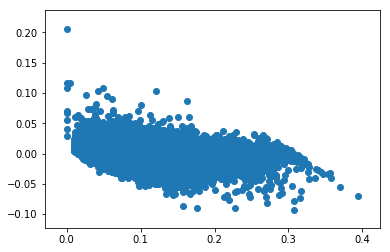

In [279]:
err = (predictions - y_test)/(1 + y_test)
plt.scatter(y_test, err)

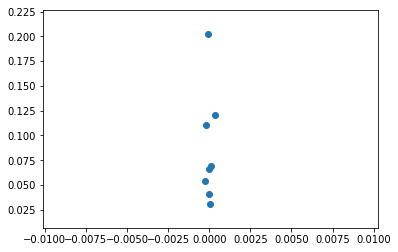

In [259]:
low_z_err = (low_z_pred - y_test_low_z)/(1 + y_test_low_z)
plt.scatter(y_test_low_z, low_z_err)

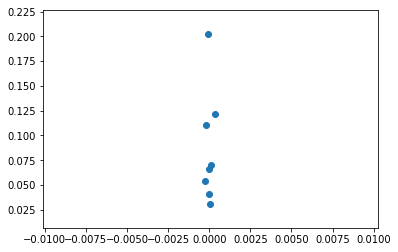

In [260]:
plt.scatter(y_test_low_z, low_z_pred)

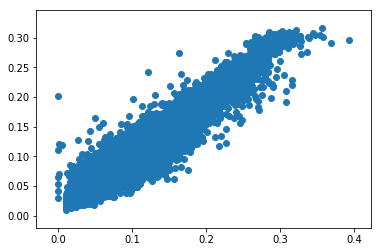

In [261]:
plt.scatter(y_test, predictions)

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns

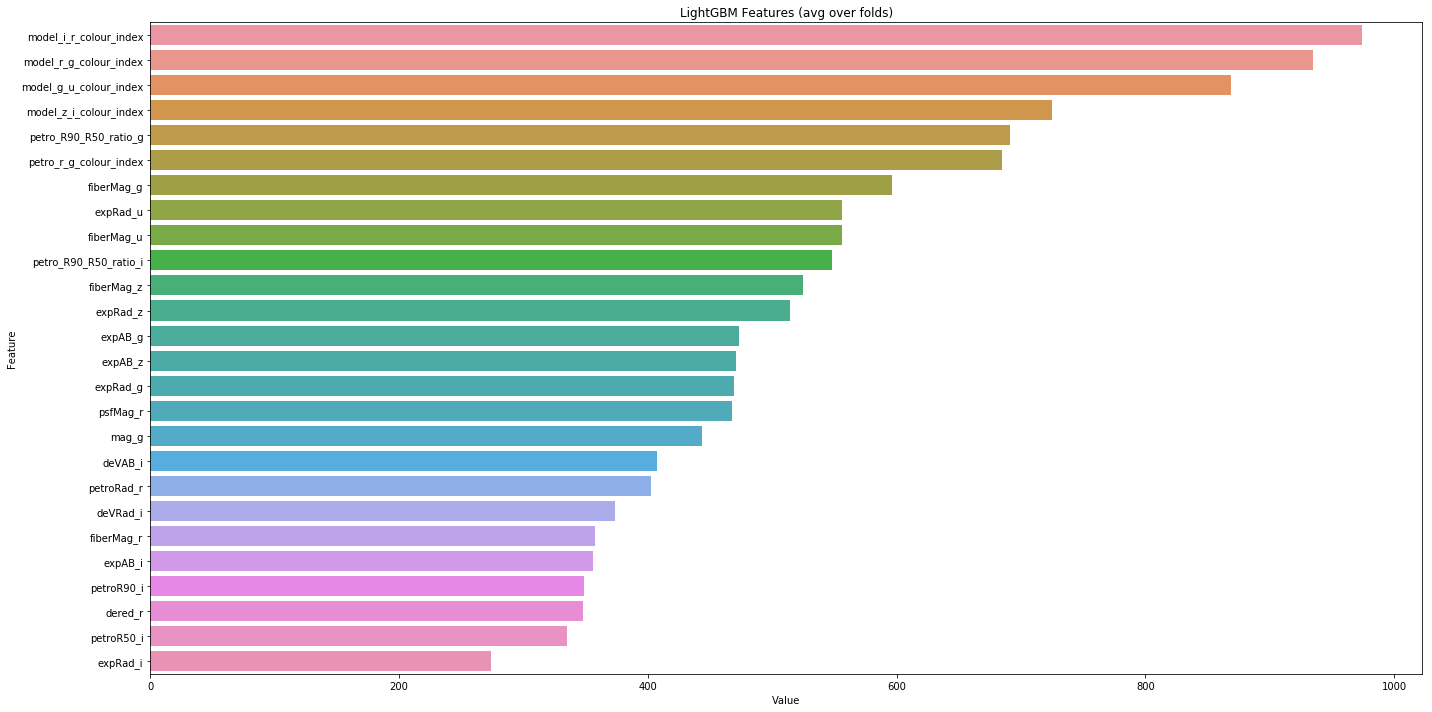

In [263]:
feature_importances = pd.DataFrame(sorted(zip(X_train[selected_features].columns, np.zeros(len(selected_features)))), columns=['Feature', 'Value'])
#feature_importances
#pd.DataFrame(sorted(zip(x_train[selected_features].columns, model.feature_importances_)), columns=['Feature', 'Value'])

# feature_importances = np.empty((len(models), len(selected_features), 2), dtype=object)
for idx, model in enumerate(models):
    feature_importance = pd.DataFrame(sorted(zip(X_train[selected_features].columns, model.feature_importances_)), columns=['Feature','Value'])
    feature_importances['Value'] += feature_importance['Value']/len(models)

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_importances.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [265]:
feature_importances.sort_values(by="Value", ascending=False)['Feature']

16    model_i_r_colour_index
17    model_r_g_colour_index
15    model_g_u_colour_index
18    model_z_i_colour_index
22     petro_R90_R50_ratio_g
24    petro_r_g_colour_index
10                fiberMag_g
8                   expRad_u
12                fiberMag_u
23     petro_R90_R50_ratio_i
13                fiberMag_z
9                   expRad_z
3                    expAB_g
5                    expAB_z
6                   expRad_g
25                  psfMag_r
14                     mag_g
0                    deVAB_i
21                petroRad_r
1                   deVRad_i
11                fiberMag_r
4                    expAB_i
20                petroR90_i
2                    dered_r
19                petroR50_i
7                   expRad_i
Name: Feature, dtype: object

In [270]:
common_features = [
    'expAB_z',
    'expRad_g',
    'model_g_u_colour_index',
    'model_i_r_colour_index',
    'petro_R90_R50_ratio_g'
]
non_common_features_importance = feature_importances[np.invert(feature_importances.Feature.isin(common_features))]
non_common_features_importance.sort_values(by="Value", ascending=False)

,Feature,Value
17,model_r_g_colour_index,935.0
18,model_z_i_colour_index,724.8
24,petro_r_g_colour_index,685.0
10,fiberMag_g,596.4
8,expRad_u,556.4
12,fiberMag_u,556.2
23,petro_R90_R50_ratio_i,548.0
13,fiberMag_z,525.0
9,expRad_z,514.6
3,expAB_g,473.0


In [274]:
selected_set = set([
    'petro_r_g_colour_index',
    'petroRad_r',
    'deVAB_i',
    'psfMag_r',
    'petro_R90_R50_ratio_i',
    'expAB_g',
    'expRad_u',
    'model_r_g_colour_index',
    'expAB_i',
    'expRad_z',
    'model_z_i_colour_index',
    'model_r_g_colour_index',
    'model_z_i_colour_index',
    'petro_r_g_colour_index',
    'fiberMag_g',
    'expRad_u',
    'fiberMag_u',
    'petro_R90_R50_ratio_i',
    'fiberMag_z',
    'expRad_z',
    'expAB_g',
])
selected_set.update(common_features)
selected_set

{'deVAB_i',
 'expAB_g',
 'expAB_i',
 'expAB_z',
 'expRad_g',
 'expRad_u',
 'expRad_z',
 'fiberMag_g',
 'fiberMag_u',
 'fiberMag_z',
 'model_g_u_colour_index',
 'model_i_r_colour_index',
 'model_r_g_colour_index',
 'model_z_i_colour_index',
 'petroRad_r',
 'petro_R90_R50_ratio_g',
 'petro_R90_R50_ratio_i',
 'petro_r_g_colour_index',
 'psfMag_r'}

In [280]:
y_test[np.abs((y_test - predictions)/(1 + y_test)) > 0.15]

493965   -0.000062
Name: z, dtype: float64

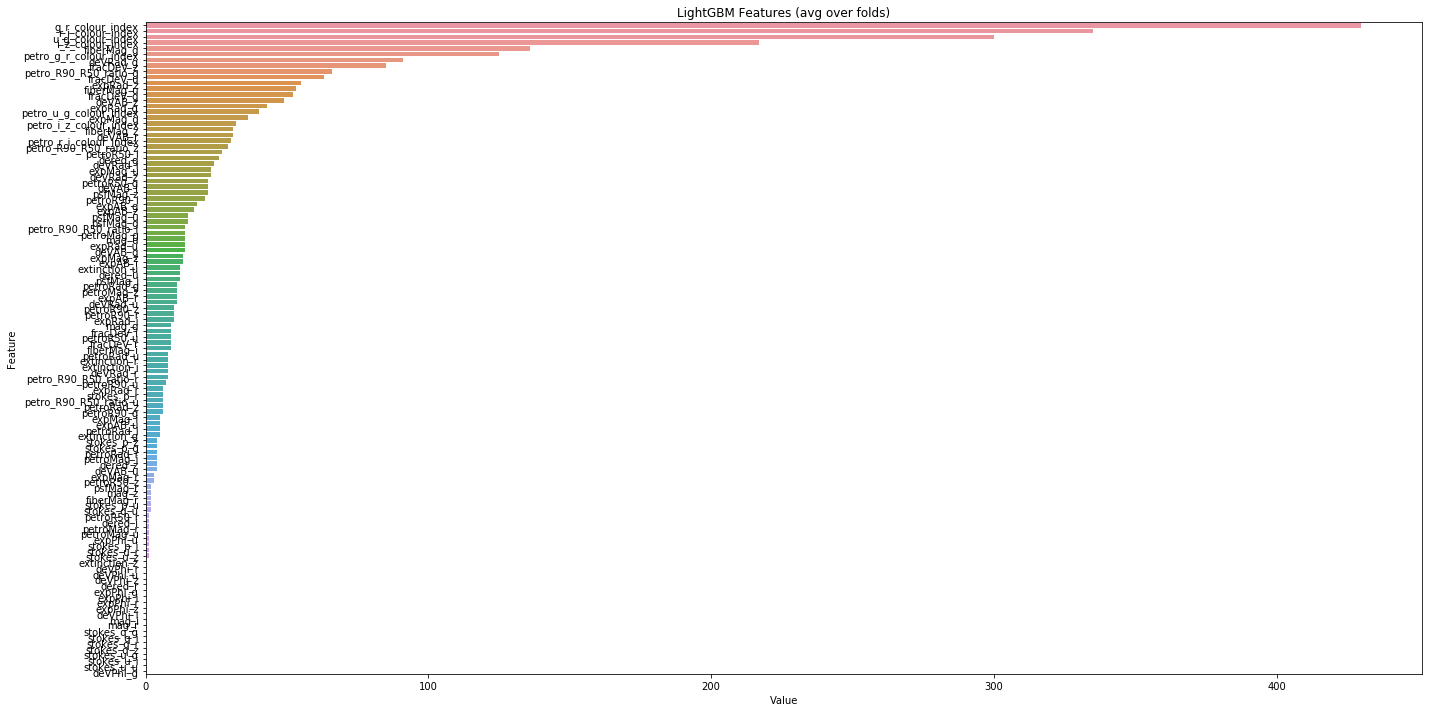

In [44]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()